In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import MNIST
from torchvision import transforms

from utils.train_utils import ModelTrainer, plot_history
from models.ibp_model import *
from utils.attacks import pgd

In [3]:
import re
import os
from datetime import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from models.layers import *


class Trainer:
    checkpoint_path = "../saved/{}_checkpoint.pt"

    def __init__(self, train_dataset, test_dataset, batch_size=(200, 200)):
        self.batch_size = batch_size
        self.train_dl = DataLoader(train_dataset, batch_size=batch_size[0], shuffle=True)
        self.test_dl = DataLoader(test_dataset, batch_size=batch_size[1], shuffle=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.logs = {}
        self.eps, self.kappa = 0, 1
        self.interval_train = False
        os.makedirs("../saved", exist_ok=True)

    @staticmethod
    def _interval_based_bound(model, c, bounds, idx):
        # requires last layer to be linear
        cW = c.t() @ model.last_layer.weight
        cb = c.t() @ model.last_layer.bias
        l, u = bounds
        return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:, None]).t()

    def _train_test_epoch(self, model, loader, loss_fn, optimizer=None):
        C = [-torch.eye(10).to(self.device) for _ in range(10)]
        for y0 in range(10):
            C[y0][y0, :] += 1

        robust_err = 0
        total_loss, accuracy = 0., 0.
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(self.device), y.to(self.device)

            lower_out, upper_out = model(torch.cat([X - self.eps, X + self.eps], dim=1))
            out = (lower_out + upper_out) / 2
            fit_loss = self.kappa * loss_fn(out, y)
            accuracy += (out.argmax(dim=1) == y).sum().item()

            robust_loss = 0
            for y0 in range(10):
                if sum(y == y0) > 0:
                    lower_bound = self._interval_based_bound(model, C[y0], model.bounds, y == y0)
                    robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y == y0]) / X.shape[0]

                    # increment when true label is not winning
                    robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()

            # combined losss
            combined_loss = self.kappa * fit_loss + (1 - self.kappa) * robust_loss

            if optimizer is not None:
                optimizer.zero_grad()
                combined_loss.backward()
                optimizer.step()
                
                if self.eps < 0.3:
                    if self.eps < 0.1:
                        self.eps += 0.000018
                    elif self.eps < 0.2:
                        self.eps += 0.000008
                    else:
                        self.eps += 0.000005
                else:
                    self.eps = 0.3

                if self.kappa > 0.5:
                    self.kappa -= 0.00008
                else:
                    self.kappa = 0.5

            total_loss += combined_loss.data.item() * X.size(0)
            end = dt.now().replace(microsecond=0)
            print(f"{self.phase_name} iteration: {k}/{len(loader)} time: {end - start}", end="\r")

            
        print(" " * 80, end="\r")

        return total_loss/len(loader.dataset), accuracy/len(loader.dataset), robust_err/len(loader.dataset)

    def _train(self, model, loss_fn, optimizer):
        model.train()
        self.phase_name = "train"
        with torch.enable_grad():
            return self._train_test_epoch(model, self.train_dl, loss_fn, optimizer)

    def _test(self, model, loss_fn):
        model.eval()
        self.phase_name = "test"
        with torch.no_grad():
            return self._train_test_epoch(model, self.test_dl, loss_fn)

    def train(self, model, loss_fn, optimizer, scheduler=None, epochs=30, patience=4):
        self.logs = {
            'loss': {"train": [], "test": []},
            'accuracy': {"train": [], "test": []},
            'robust error': {"train": [], "test": []},
        }
        model = model.to(self.device)
        epochs_no_improve, min_loss = np.inf, float('inf')
        min_robust_err = float('inf')
        model_name = re.sub(r'\W+', '', str(model.__class__).split(".")[-1])

        for e in range(1, epochs+1):
            start = dt.now().replace(microsecond=0)
            print(f"epoch start with: eps: {self.eps:.8f}, kappa: {self.kappa:.8f}")
            train_loss, train_acc, train_err = self._train(model, loss_fn, optimizer)
            test_loss, test_acc, test_err = self._test(model, loss_fn)
            followed_metric = test_loss
            if scheduler is not None:
                scheduler.step(followed_metric)
            end = dt.now().replace(microsecond=0)
            out = "Epoch: {} Validation Loss: {:.4f} accuracy: {:.4f}, robust err: {:.4f}, time: {}"
            print(out.format(e, test_loss, test_acc, test_err, end - start), end="\n\n")

            # Update logs
            self.logs['loss']["train"].append(train_loss)
            self.logs['loss']["test"].append(test_loss)
            self.logs['accuracy']["train"].append(train_acc)
            self.logs['accuracy']["test"].append(test_acc)
            self.logs['robust error']["train"].append(train_err)
            self.logs['robust error']["test"].append(test_err)

            if self.eps == 0.3 and min_robust_err > test_err:
                min_robust_err = test_err
                torch.save(model.state_dict(), Trainer.checkpoint_path.format(str(e)+model_name))
            # Early stopping
            if followed_metric < min_loss:
                min_loss = followed_metric
                epochs_no_improve = 0
                torch.save(model.state_dict(), Trainer.checkpoint_path.format(model_name))
            else:
                epochs_no_improve += 1
#                 print(f"epochs_no_improve: {epochs_no_improve}/{patience}")
#                 if epochs_no_improve == patience:
#                     print('Early stopping!')
#                     break

        model.load_state_dict(torch.load(Trainer.checkpoint_path.format(model_name),
                                         map_location=self.device))
        return self.logs


def plot_history(hists):
    x = np.arange(1, len(hists["loss"]["test"]) + 1)
    f, axes = plt.subplots(nrows=1, ncols=len(hists), figsize=(15, 5))
    for ax, (name, hist) in zip(axes, hists.items()):
        for label, h in hist.items():
            ax.plot(x, h, label=label)

        ax.set_title("Model " + name)
        ax.set_xlabel('epochs')
        ax.set_ylabel(name)
        ax.legend(loc="best")

    f.savefig("model.png", dpi=f.dpi)

In [4]:
tr_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = MNIST('../data', train=True, download=True, transform=tr_transform)
ds_test = MNIST('../data', train=False, download=True, transform=vl_transform)

cuda
epoch start with: eps: 0.00000000, kappa: 1.00000000
Epoch: 1 Validation Loss: 0.3540 accuracy: 0.9139, robust err: 0.5366, time: 0:00:46

epoch start with: eps: 0.01080000, kappa: 0.95200000
Epoch: 2 Validation Loss: 0.2632 accuracy: 0.9411, robust err: 0.2949, time: 0:00:51

epoch start with: eps: 0.02160000, kappa: 0.90400000
Epoch: 3 Validation Loss: 0.2376 accuracy: 0.9506, robust err: 0.2175, time: 0:00:53

epoch start with: eps: 0.03240000, kappa: 0.85600000
Epoch: 4 Validation Loss: 0.2224 accuracy: 0.9569, robust err: 0.1779, time: 0:00:53

epoch start with: eps: 0.04320000, kappa: 0.80800000
Epoch: 5 Validation Loss: 0.2272 accuracy: 0.9596, robust err: 0.1646, time: 0:00:47

epoch start with: eps: 0.05400000, kappa: 0.76000000
Epoch: 6 Validation Loss: 0.2234 accuracy: 0.9609, robust err: 0.1516, time: 0:00:51

epoch start with: eps: 0.06480000, kappa: 0.71200000
Epoch: 7 Validation Loss: 0.2205 accuracy: 0.9644, robust err: 0.1380, time: 0:00:52

epoch start with: eps:

Epoch: 59 Validation Loss: 0.4074 accuracy: 0.9558, robust err: 0.2033, time: 0:00:53

epoch start with: eps: 0.28672500, kappa: 0.50000000
Epoch: 60 Validation Loss: 0.4118 accuracy: 0.9553, robust err: 0.2047, time: 0:00:53

epoch start with: eps: 0.28972500, kappa: 0.50000000
Epoch: 61 Validation Loss: 0.4156 accuracy: 0.9548, robust err: 0.2075, time: 0:00:52

epoch start with: eps: 0.29272500, kappa: 0.50000000
Epoch: 62 Validation Loss: 0.4184 accuracy: 0.9551, robust err: 0.2082, time: 0:00:53

epoch start with: eps: 0.29572500, kappa: 0.50000000
Epoch: 63 Validation Loss: 0.4229 accuracy: 0.9544, robust err: 0.2109, time: 0:00:46

epoch start with: eps: 0.29872500, kappa: 0.50000000
Epoch: 64 Validation Loss: 0.4230 accuracy: 0.9540, robust err: 0.2107, time: 0:00:48

epoch start with: eps: 0.30000000, kappa: 0.50000000
Epoch: 65 Validation Loss: 0.4209 accuracy: 0.9541, robust err: 0.2096, time: 0:00:50

epoch start with: eps: 0.30000000, kappa: 0.50000000
Epoch: 66 Validation

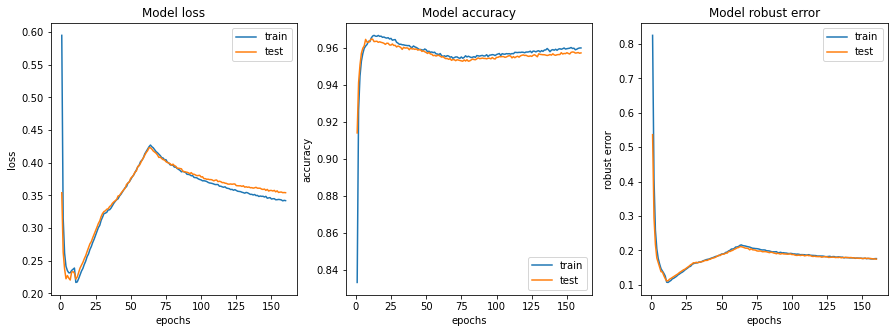

In [6]:
trainer = Trainer(ds_train, ds_test, batch_size=(100, 100))
model = MnistIBPModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-4,
                                                 patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=160, patience=6)
plot_history(history)
torch.save(model.state_dict(), "../saved/ibp_model.pt")